# Demo: SQUANCH Agents and Channels
### Ben Bartlett, 7.20.17

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mp
import time

%matplotlib inline

from squanch import qstream, gates, agent

## Description

Alice, Bob, and Charlie are all instantiated as agent object, with bidirectional quantum channels between them. Alice and Bob connected by 1km of fiber optic cable, and Charlie is at the midpoint, 0.5km from both Alice and Bob. 

Charlie distributes bell pairs to Alice and Bob, who store them in their quantum memories. Some time later, Alice begins to encode her classical data in the entangled qubits stored in her quantum memroy and sends them to Bob, who disentangles them and serializes the raw bit data back into an appropriately-sized image array.

A schematic of this scneario is shown below.

![Transmission scheme](http://i.imgur.com/HEK11LIl.jpg)

### Instantiating the Agents
Agents are instantiated with unique identifiers. Connecting agents to each other creates bidirecitonal quantum and classical communication channels and reserves a section of the agents' quantum memories for transmission from the other agent.

In [6]:
# Create Alice, Bob, and Charlie as agents. 
# Charlie will distribute Bell pairs to Alice and Bob, and Alice will send the 
# image data to Bob using these distributed pairs.
alice = agent.Agent("Alice")
bob = agent.Agent("Bob")
charlie = agent.Agent("Charlie")

# Connect Alice, Bob, and Charlie. Charlie is at the midpoint of Alice and Bob, 
# who are 1km apart from each other.
agent.connectAgents(alice, bob, length = 1.0)
agent.connectAgents(alice, charlie, length = 0.5)
agent.connectAgents(bob, charlie, length = 0.5)

### The distribution, encoding, and decoding logic

These are coded as a series of quantum gates. The syntactic sugar of Qubit and QSystem objects allows for you to work intuitively with the objects, "sending" qubits down channels and putting them in memory, but only actually maintains a lightweight set of references to array locations in the parent QStream object.

In [7]:
def charlieDistributesBellPair(qStream):
    '''Charlie creates Bell pairs from a qStream object and distributes 
    them between Alice and Bob'''

    # Get the qubits from the next system to distribute
    pair = qStream.head()
    qa, qb = pair.qubits
    # Prepare the bell pair 
    gates.H(qa)
    pair.apply(gates._CNOT)
    # Send the photons in the bell pair to Alice and Bob
    charlie.qsend(alice, qa)
    charlie.qsend(bob, qb)
    # Alice and Bob receive their qubits 
    alice.qrecv(charlie)
    bob.qrecv(charlie)

def aliceEncodesBitPair(bit1, bit2):
    '''Alice uses a single entangled qubit stored in her quantum memory 
    to encode a bit pair to send to Bob'''

    # Retrieve the next of Charlie's qubits from Alice's quantum memory 
    qubit = alice.qmem[charlie].pop(0)
    # If the qubit is not corrupted, Alice encodes her bits
    if qubit is not None:
        if bit2 == 1: gates.X(qubit)
        if bit1 == 1: gates.Z(qubit)
    # Alice sends the qubit to Bob 
    alice.qsend(bob, qubit)
    # Bob receives his qubit from Alice
    bob.qrecv(alice)

def bobDecodesBitPair():
    '''Bob combines a qubit received from Alice with one previously received 
    from Charlie to reconstruct the transmitted bit pair.'''

    # Retrieve Alice's and Charlie's qubuts from Bob's quantum memory 
    qa = bob.qmem[alice].pop(0)
    qc = bob.qmem[charlie].pop(0)
    # If either qubit is corrupted, replace both bits with 0
    if qa is None or qc is None: return 0, 0
    # Bob disentangles the qubits 
    qa.qSystem.apply(gates._CNOT)
    gates.H(qa)
    # Measure the results
    bit1 = qa.measure()
    bit2 = qc.measure()
    return bit1, bit2

### Run the transmission

Load the color data of an image as an array, then serialize it to a bitstream. Instantiate a QStream of the appropriate size, then, in sequence, call Charlie's distribution protocol, then Alice's encoding protocol, then Bob's decoding protocol. Qubits are stored in agents' quantum memories during intermediate steps.

0.000s: Charlie distributing bell pairs...


4.536s: Alice encoding her data and sending to Bob...


8.310s: Bob disentangling and reading out quantum data...


16.573s: Simulation of 216384-bit transmission complete.


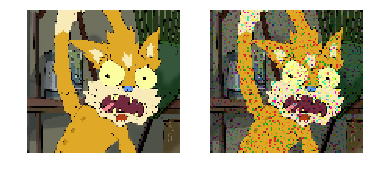

In [8]:
# Load the image 
imgData = mp.image.imread("img/squanchy.bmp")

# Convert the image array to a bitstream
aliceBits = np.unpackbits(imgData)
bobBits = np.zeros(aliceBits.size, dtype = np.uint8)
# Instantiate the QStream object of proper size 
numQuantumSystems = len(aliceBits) / 2
qs = qstream.QStream(2, numQuantumSystems)

# Start the timer 
start = time.time()

# Charlie distributes bell pairs and Alice and Bob store them in their quantum memories
print "{:.3f}s: Charlie distributing bell pairs...".format(time.time() - start)
for _ in range(numQuantumSystems):
    charlieDistributesBellPair(qs)

# Some time later, Alice encodes her data and sends to Bob 
print "{:.3f}s: Alice encoding her data and sending to Bob...".format(time.time() - start)
for i in range(numQuantumSystems):
    aliceEncodesBitPair(aliceBits[2 * i], aliceBits[2 * i + 1])

# Finally, Bob decodes and reads out the data
print "{:.3f}s: Bob disentangling and reading out quantum data...".format(time.time() - start)
for i in range(numQuantumSystems):
    bobBits[2 * i], bobBits[2 * i + 1] = bobDecodesBitPair()

# Stop the timer 
stop = time.time()
print "{:.3f}s: Simulation of {}-bit transmission complete.".format(stop - start, len(bobBits))

# Repackage the received data in an image format
receivedArray = np.reshape(np.packbits(bobBits), imgData.shape)

# Plot the data 
f, ax = plt.subplots(1, 2)
ax[0].imshow(imgData)
ax[0].axis('off')
ax[1].imshow(receivedArray)
ax[1].axis('off')
plt.show()